# Исследование успешности игры

# Описание проекта 
Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). 

Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Имеются данные до 2016 года. Представим, что сейчас декабрь 2016 г., и планируется кампания на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируются продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Откроем файл с данными и изучим общую информацию

**1. Загрузим данные из файла в датафрейм.**

In [1]:
#импорт библитек
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
games = pd.read_csv('/Users/olya/Desktop/Портфолио/Сборный проект -1/games.csv')
display(games.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**2. Изучим общую информацию о полученном датафрейме.**

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Количество значений в столбцах различается, значит, в данных есть пропущенные значения, которые стоит изучить. Также необходимо привести названия колонок к нижнему регистру, преобразовать типы данных в некоторых столбцах. Этим и займемся на этапе предобработки данных.

## Предобработка данных

**1) Заменим названия столбцов (приведем к нижнему регистру):**

In [4]:
games.columns = games.columns.str.lower()

**2) Преобразуем данные в нужные типы:**

In [5]:
#год переведем к типу данных object, пропущенные значения заменим заведомо маленьким годом (1900), что будет означать отсутсвие даты релиза.
games['year_of_release'] = games['year_of_release'].fillna(1900)
games['year_of_release'] = games['year_of_release'].astype('int') 
print(games['year_of_release'].unique())#проверка

#games['user_score'] = games['user_score'].astype('float') #user_score заменим на тип float, тк оценка пользователей 
#не обязательно целое число. Выдает ошибку, тк встречается значение 'tbd', заменим это значение на nan

[2006 1985 2008 2009 1996 1989 1984 2005 1999 2007 2010 2013 2004 1990
 1988 2002 2001 2011 1998 2015 2012 2014 1992 1997 1993 1994 1982 2016
 2003 1986 2000 1900 1995 1991 1981 1987 1980 1983]


In [6]:
games.loc[games['user_score'] == 'tbd','user_score'] = np.nan
#теперь можем спокойно изменить тип данных
games['user_score'] = games['user_score'].astype('float')

In [7]:
games.info() #проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


***3) Обработка пропусков:***

In [8]:
print(games.isna().sum())

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


Пропуски в столбце name заполнить не можем, тк не знаем название игры, но и удалять такие строки не стоит, тк по ним есть другая ценная для нас информация, аналогично со столбцом "genre". critic_score и user_score тоже заполнять не будем, тк не знаем почему нет информации + на одной платформе игра может иметь хороший рейтинг, на другой нет. Лучше оставить эти строки пустыми.
В столбце rating заменим пропущенные значения фразой "non rating", так мы будем понимать, что рейтинг игры отсутствует в датафрейме по каким-то причинам и мы определили такие игры в категорию "Без рейтинга".

В целом, пропуски могли быть связаны с технической ошибкой (возможно часть значений в столбцах critic_score и user_score пропущенны именно по ней), или попросту отсутствием информации как, например, в столбце с рейтингом ESRB для Японских игр пропуск связан с использованием другой рейтинговой сиситемы.

In [9]:
games['rating'] = games['rating'].fillna('no rating')

In [10]:
print(games.isna().sum())#проверка

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating                0
dtype: int64


**4) Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец:**

In [11]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no rating,31.38


**Выводы:**

В ходе предобработки данных:
- переименовали столбцы;
- изменили типы данных столбцов 'year_of_release' и 'user_score';
- обработали пропуски;
- дополнили датафрейм столбцом с данными о суммарных продажах в регионах.

## Исследовательский анализ данных

**1) Посмотрим, сколько игр выпускалось в разные годы:**

In [12]:
games.pivot_table(index='year_of_release', values='rating', aggfunc='count').reset_index()

,year_of_release,rating
0,1900,269
1,1980,9
2,1981,46
3,1982,36
4,1983,17
5,1984,14
6,1985,14
7,1986,21
8,1987,16
9,1988,15


Пока что оставим данные за все года, в дальнейшем поймем какие года все таки будут актуальными и будем использовать только актуальные. Помним, 1900 - заглушка.

**2) Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. Узнаем за какой срок появляются новый и исчезают старые платформы:**

In [13]:
platform_top = games.groupby('platform')['total_sales'].agg('sum').reset_index()
platform_top = pd.DataFrame(platform_top).sort_values(by='total_sales', ascending=False)
display(platform_top.head(20))

,platform,total_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86
6,GBA,317.85
18,PS4,314.14
19,PSP,294.05
13,PC,259.52


Наибольшие суммарные продажи у платформ PS и XB. Построим за какой период они появлялись и исчезали.

Для платформы PS:

In [29]:
games_ps[['year_of_release', 'total_sales']]
g_games_ps = games_ps.groupby('year_of_release').agg({'total_sales': 'sum'}).reset_index()
g_games_ps

,year_of_release,total_sales
0,1900,3.28
1,1994,6.03
2,1995,35.96
3,1996,94.70
4,1997,136.17
5,1998,169.49
6,1999,144.53
7,2000,96.37
8,2001,35.59
9,2002,6.67


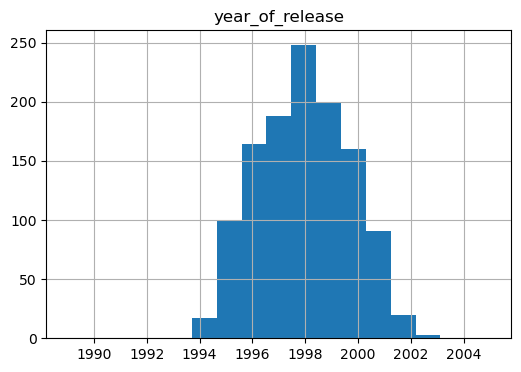

In [62]:
games_ps = games.loc[games['platform'] == 'PS']

games_ps.hist('year_of_release', bins=17, range = (1989, 2005), figsize=(6, 4));



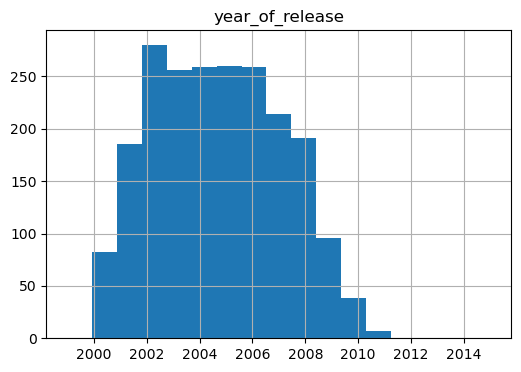

In [44]:
games_ps2 = games.loc[games['platform'] == 'PS2']

games_ps2.hist('year_of_release', bins=17, range = (1999, 2015), figsize=(6, 4));

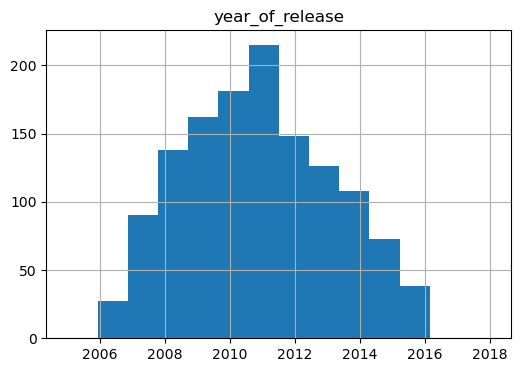

In [45]:
games_ps3 = games.loc[games['platform'] == 'PS3']

games_ps3.hist('year_of_release', bins=14, range = (2005, 2018), figsize=(6, 4));

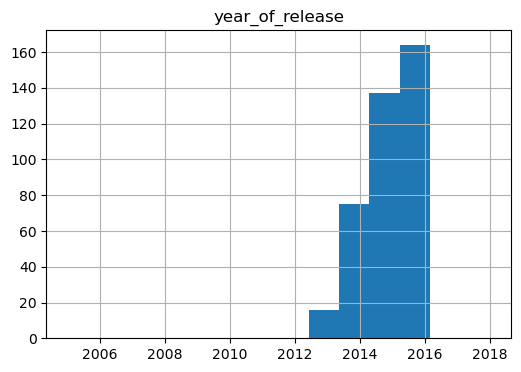

In [46]:
games_ps4 = games.loc[games['platform'] == 'PS4']

games_ps4.hist('year_of_release', bins=14, range = (2005, 2018), figsize=(6, 4));

Анализируя полученные 4 графика, можно заметить, что новые платформы ps появляются за 6 лет. Исчезают примерно за 10 лет.

Для платформы ХB:

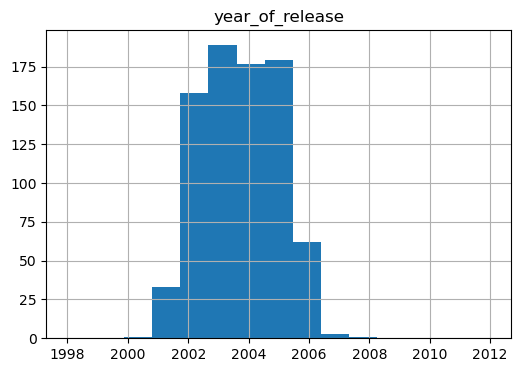

In [47]:
games_XB = games.loc[games['platform'] == 'XB']

games_XB.hist('year_of_release', bins=15, range = (1998, 2012), figsize=(6, 4));

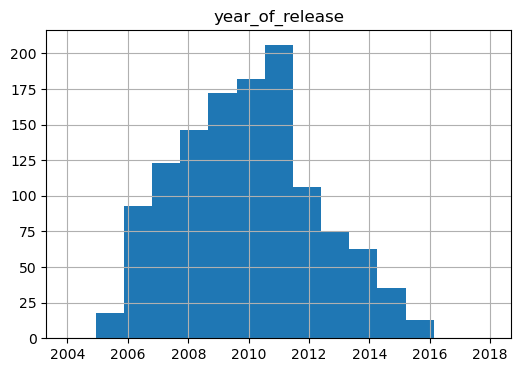

In [48]:
games_X360 = games.loc[games['platform'] == 'X360']

games_X360.hist('year_of_release', bins=15, range = (2004, 2018), figsize=(6, 4));

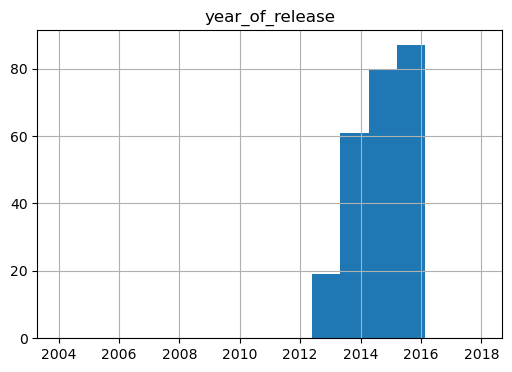

In [49]:
games_XOne = games.loc[games['platform'] == 'XOne']

games_XOne.hist('year_of_release', bins=15, range = (2004, 2018), figsize=(6, 4));

Новые платформы XB появляются примерно за 6 лет, исчезают за 10.

**3) Возьмем данные за соответствующий актуальный период. Актуальными данными будем считать данные начиная с 2013 года, тк в этот год вышли приставки нового поколения. Данные за предыдущие года учитывать не будем:**

In [50]:
actual_games = games.loc[games['year_of_release'] > 2012]
display(actual_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01


**4) Выясним какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ:**

In [51]:
platform_top_actual = actual_games.groupby('platform')['total_sales'].agg('sum').reset_index()
platform_top_actual = pd.DataFrame(platform_top_actual).sort_values(by='total_sales', ascending=False)
display(platform_top_actual)

,platform,total_sales
4,PS4,314.14
3,PS3,181.43
10,XOne,159.32
0,3DS,143.25
9,X360,136.80
8,WiiU,64.63
2,PC,39.43
6,PSV,32.99
7,Wii,13.66
5,PSP,3.50


Рассмотрим платформы PS и XB как лидирующие. По диаграммам выше, можем сделать вывод, что ps3 и X360 теряют в продажах, а PS4 и XOne растут, при этом XOne уступает в два раза PS4. Хотелось бы отобрать топ-5 платформ, поэтому дополнительно изучим данные и по другим платформам. 

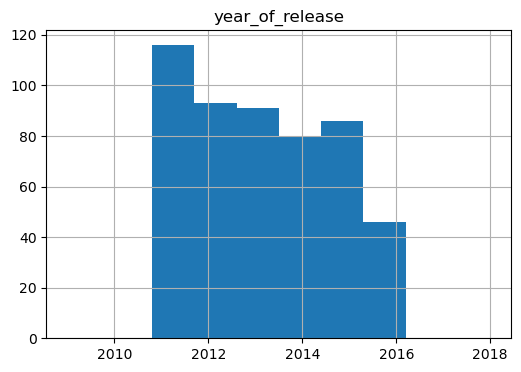

In [52]:
games_3DS = games.loc[games['platform'] == '3DS']

games_3DS.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Продажи 3DS в 2016 году резко упали, но до полного вымирания платформы еще 4 года, поэтому включим 3DS в список потенциально прибыльных платформ.

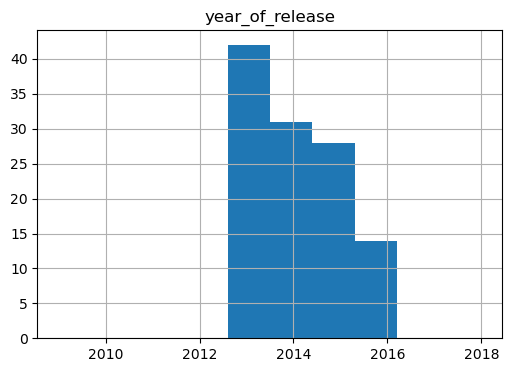

In [53]:
games_WiiU = actual_games.loc[games['platform'] == 'WiiU']

games_WiiU.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Продажи платформы WiiU падают, тоже минус.

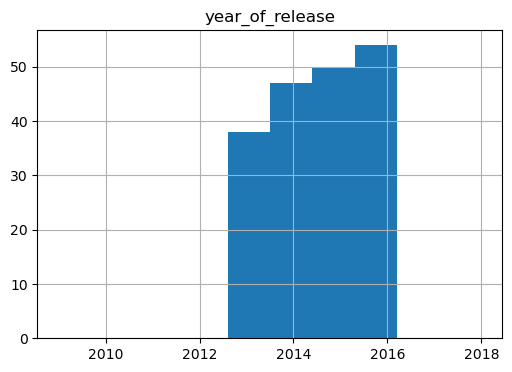

In [54]:
games_PC = actual_games.loc[games['platform'] == 'PC']

games_PC.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Продажи растут, это хороший знак. Добавим РС в наш топ 5.

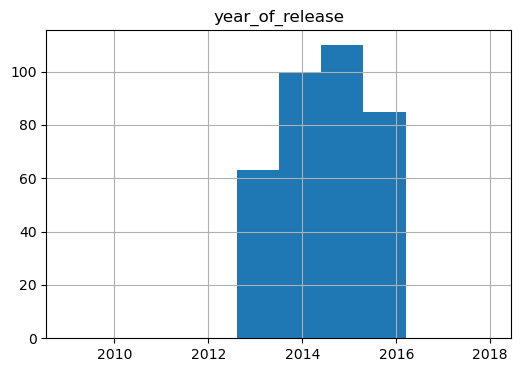

In [55]:
games_PSV = actual_games.loc[games['platform'] == 'PSV']

games_PSV.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Продажи хоть и начали падать, но все еще достаточно высоки, до "вымирания" платформы примерно 6 лет, думаю ее стоит включить в топ.

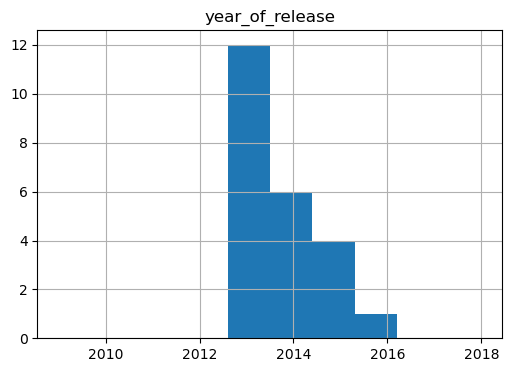

In [56]:
games_Wii = actual_games.loc[games['platform'] == 'Wii']

games_Wii.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Все плохо.

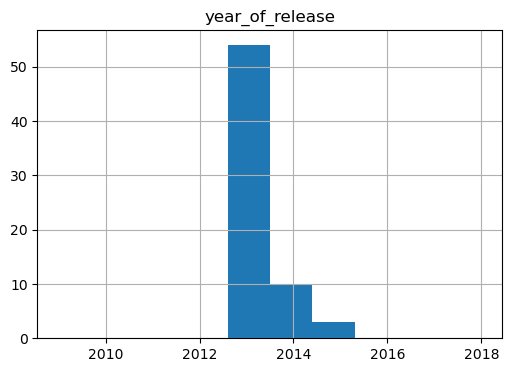

In [57]:
games_PSP = actual_games.loc[games['platform'] == 'PSP']

games_PSP.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Все плохо.

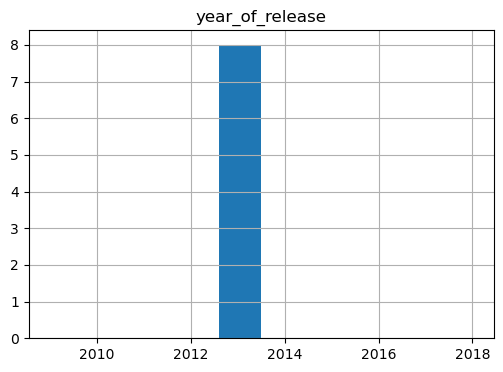

In [58]:
games_DS = actual_games.loc[games['platform'] == 'DS']

games_DS.hist('year_of_release', bins=10, range = (2009, 2018), figsize=(6, 4));

Вымерла.

В итоге, выбрав лучших и лучших из худших отдадим предпочтение РS4, XOne, 3DS, PC, PSV.

**6) Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.**

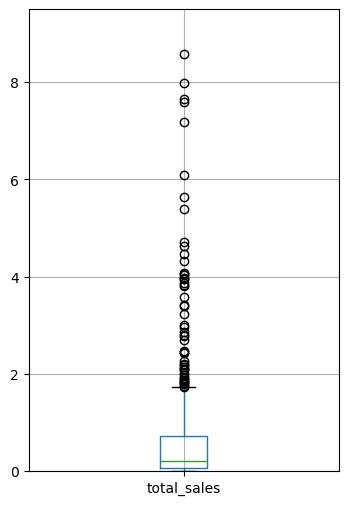

In [63]:
plot_ps4 = games_ps4.boxplot('total_sales', figsize=(4, 6)).set_ylim(0, 9.5)

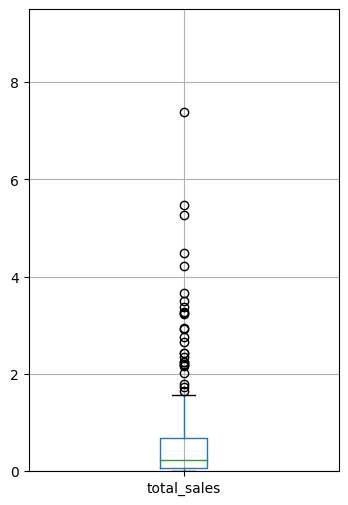

In [64]:
plot_XOne = games_XOne.boxplot('total_sales', figsize=(4, 6)).set_ylim(0, 9.5)

Имеется достаточно большое количество выбрасов + медиана находится ниже среднего значения, что говорит о том, что какие-то игры пользователям заходят лучше, какие-то хуже и разброс достаточно большой.

**График с полными данными для наглядности выбросов**

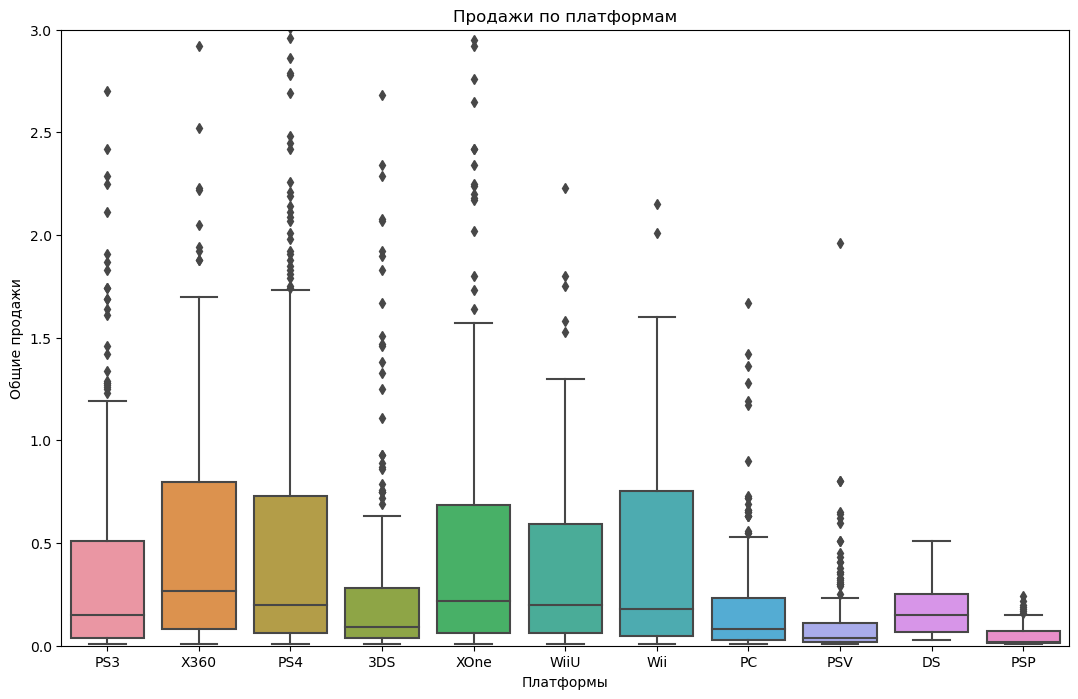

In [60]:
plt.figure(figsize=(13, 8))
(sns.boxplot(data = actual_games, x='platform', y = 'total_sales')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 3)))

plt.show()

**Ограниченный график, чтобы оценить квантили и медиану**

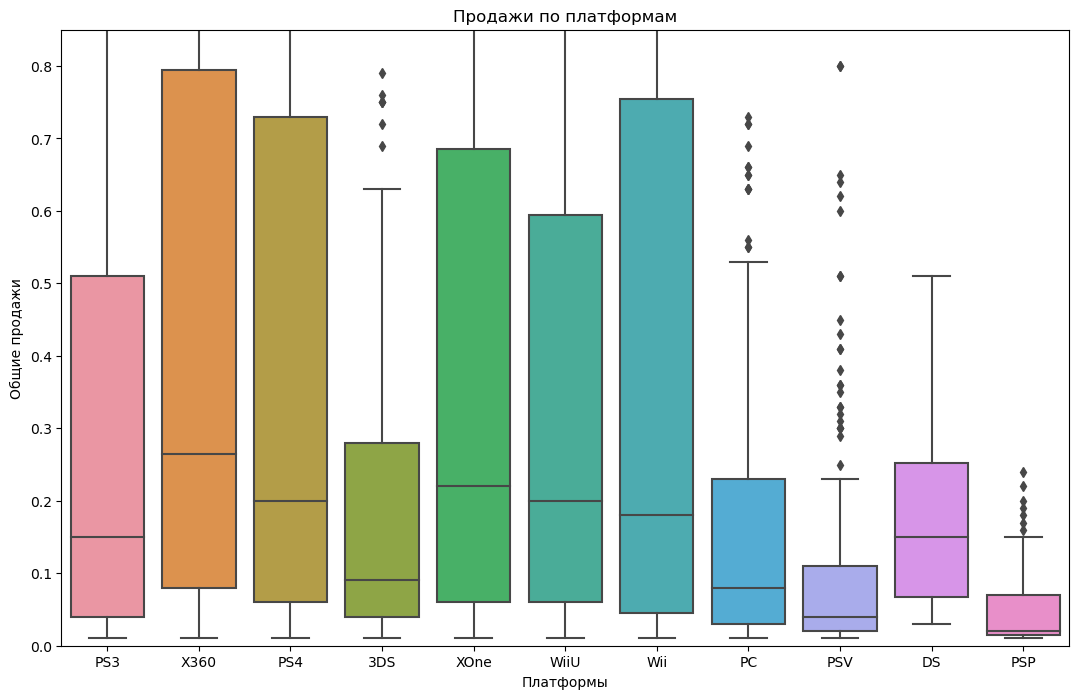

In [61]:
plt.figure(figsize=(13, 8))
(sns.boxplot(data = actual_games, x='platform', y = 'total_sales')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи', ylim=(0, 0.85)))

plt.show()

Вывод: медиана всех платформ ближе к нижнему квантилю, это значит, что преобладают игры с небольшими продажами и небольшим числом мегапопулярных игр.

**7) Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.**

Коэффициент корреляции между отзывами критиков и продажами: 0.4065679020617816


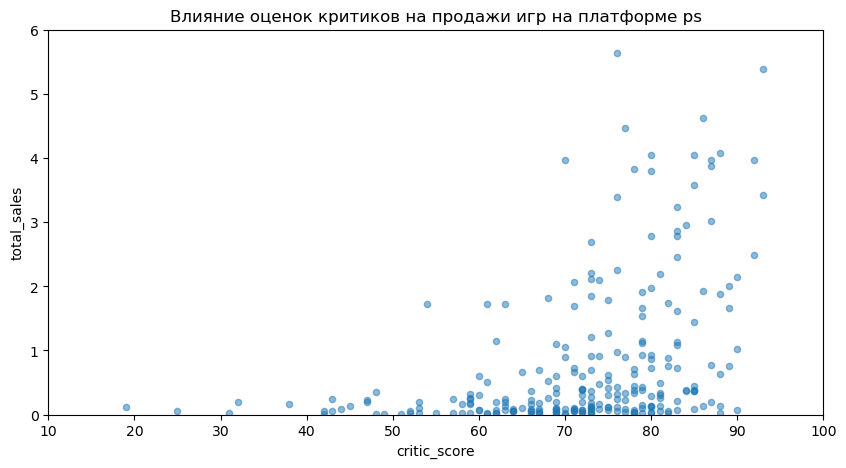

In [65]:
(
    games_ps4.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter', figsize=(10, 5), xlim = (10, 100), 
    ylim = (0, 6), alpha = 0.5, title = 'Влияние оценок критиков на продажи игр на платформе ps')
);

print('Коэффициент корреляции между отзывами критиков и продажами:', games_ps4['total_sales'].corr(games_ps4['critic_score']))

Коэффициент корреляции между отзывами пользователей и продажами: -0.03195711020455643


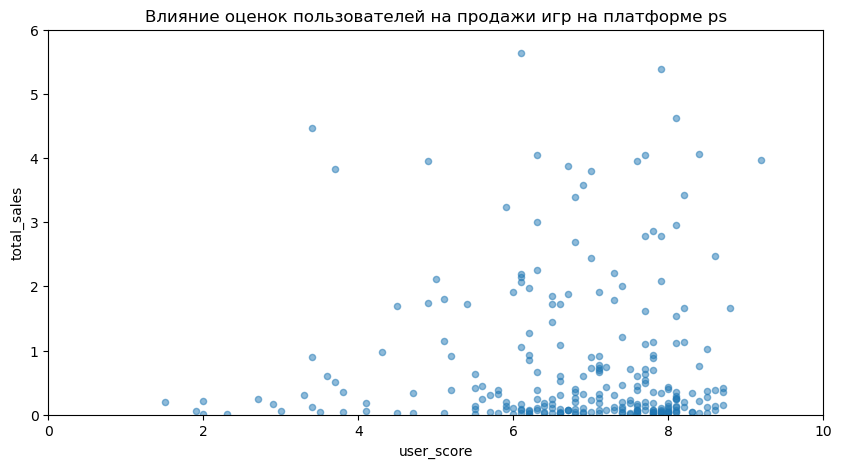

In [66]:
(
    games_ps4.plot(x = 'user_score', y = 'total_sales', kind = 'scatter', figsize=(10, 5), xlim = (0, 10), 
    ylim = (0, 6), alpha = 0.5, title = 'Влияние оценок пользователей на продажи игр на платформе ps')
);
print('Коэффициент корреляции между отзывами пользователей и продажами:', games_ps4['total_sales'].corr(games_ps4['user_score']))

Вывод: связь между отзывами критиков на платформе ps и продажами присутствует, но слабая, возможно, при покупке игры, некоторые пользователи обращают на них внимание. Связи между оценками пользователей и продажами нет.

**8) Соотнесем выводы с продажами игр на других платформах.**

Проверим, будет ли аналогичный вывод при исследовании платформы XB

Коэффициент корреляции между отзывами критиков и продажами: 0.41699832800840164


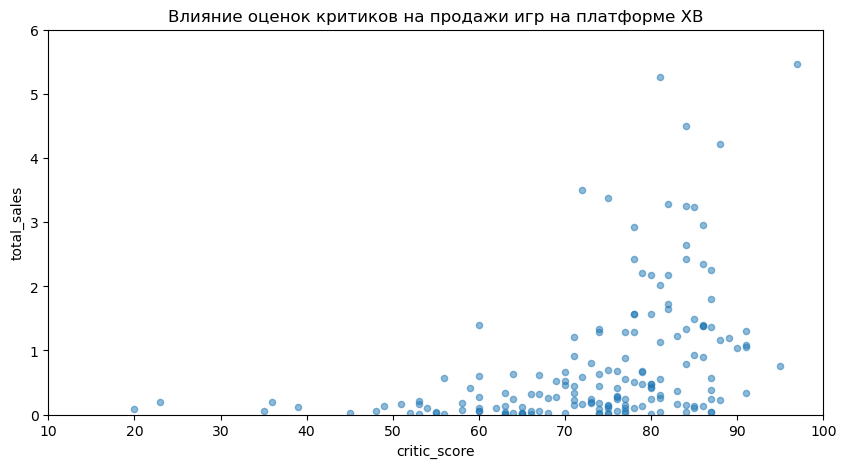

In [67]:
(
    games_XOne.plot(x = 'critic_score', y = 'total_sales', kind = 'scatter', figsize=(10, 5), xlim = (10, 100), 
    ylim = (0, 6), alpha = 0.5, title = 'Влияние оценок критиков на продажи игр на платформе XB')
);

print('Коэффициент корреляции между отзывами критиков и продажами:', games_XOne['total_sales'].corr(games_XOne['critic_score']))

Коэффициент корреляции между отзывами пользователей и продажами: -0.06892505328279415


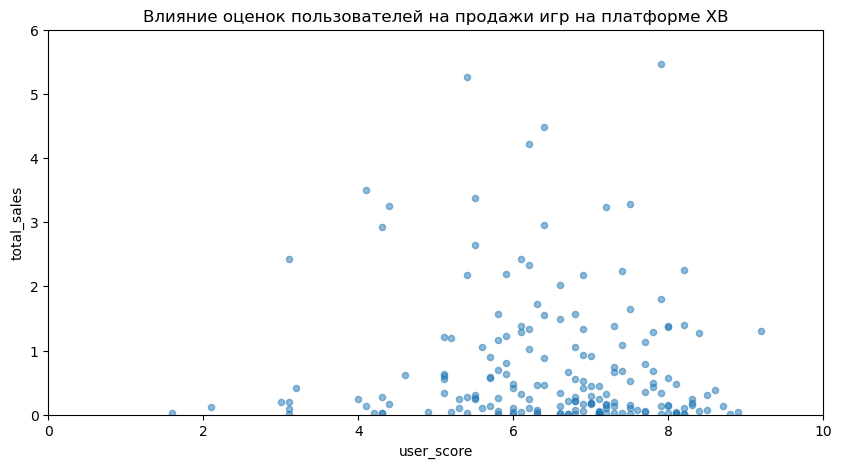

In [68]:
(
    games_XOne.plot(x = 'user_score', y = 'total_sales', kind = 'scatter', figsize=(10, 5), xlim = (0, 10), 
    ylim = (0, 6), alpha = 0.5, title = 'Влияние оценок пользователей на продажи игр на платформе XB')
);

print('Коэффициент корреляции между отзывами пользователей и продажами:', games_XOne['total_sales'].corr(games_XOne['user_score']))

Наш вывод подтвердился, следовательно, данный вывод мы можем соотнести с продажами игр на других платформах. Получается, что продажа частично зависят от оценки критиков и не зависят от оценкт пользователей.

**9) Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

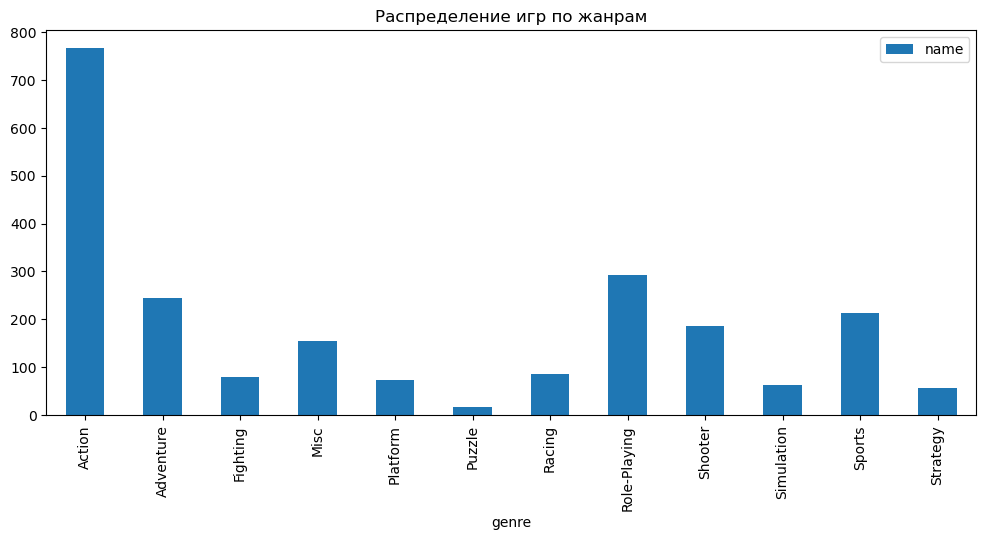

In [69]:
(
    actual_games.groupby('genre').agg({'name':'count'}).reset_index()
    .plot(x = 'genre', y = 'name', kind = 'bar', figsize=(12, 5), title = 'Распределение игр по жанрам')
);

Больше всего игр в жанре Экшен.

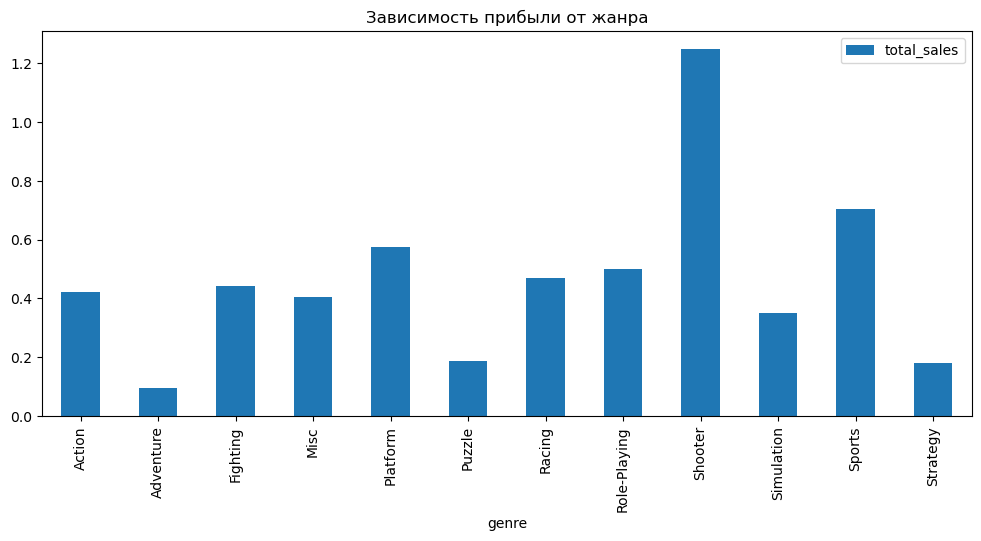

In [71]:
(
    actual_games.pivot_table(index='genre', values='total_sales', aggfunc='mean').reset_index()
    .plot(x = 'genre', y = 'total_sales', kind = 'bar', figsize=(12, 5), title = 'Зависимость прибыли от жанра')
);

Вывод: самым прибыльным оказался жанр Shooter, остальные сильно уступают ему. Самая маленькая средняя прибыль у жанра adventure.

## Составим портрет пользователя каждого региона

**Определите для пользователя каждого региона (NA, EU, JP):**
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

*1) Самые популярные платформы*

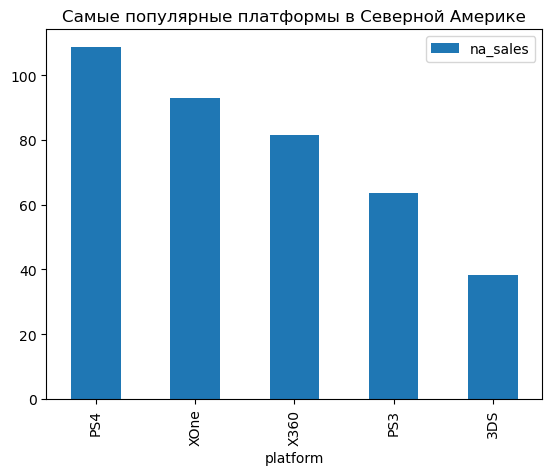

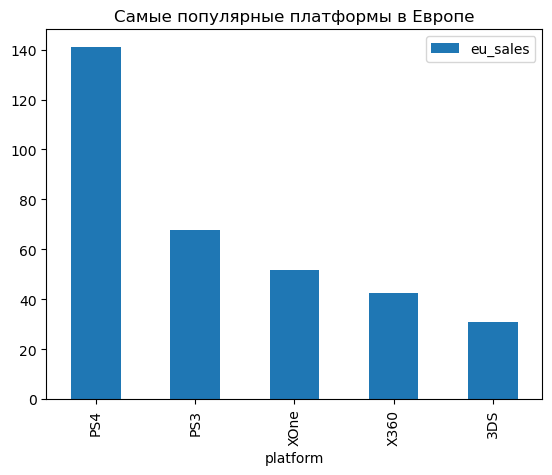

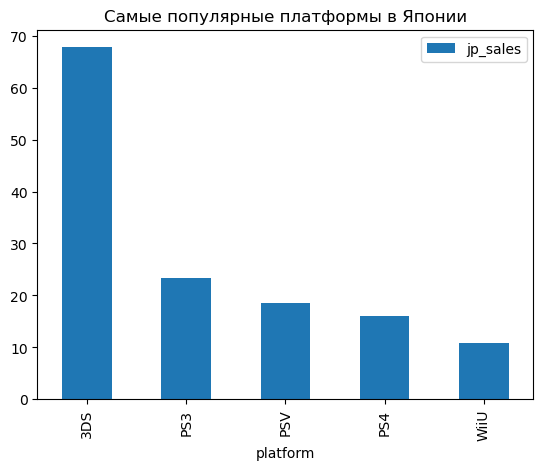

In [72]:
actual_games.groupby(by='platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar', title = 'Самые популярные платформы в Северной Америке');

actual_games.groupby(by='platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar', title = 'Самые популярные платформы в Европе');

actual_games.groupby(by='platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar', title = 'Самые популярные платформы в Японии');

В Северной Америке самыми популярными оказались платформы PS и XB и находятся примерно на одном уровне. В пятерку также вошла 3DS. В Европе наибольшую популярность имеет платформа PS4, в Японии в лидерство выбивается 3DS, тк это японская компания, возможно, лидерство обусловленно тем, что на платформе выходили игры, актуальные для Японии (анимешные какие-то...), + это прототипная платформа, удобно взять с собой. На втором месте PS, скорее всего потому что это японская платформа, а XB американская.

*2) Самые популярные жанры*

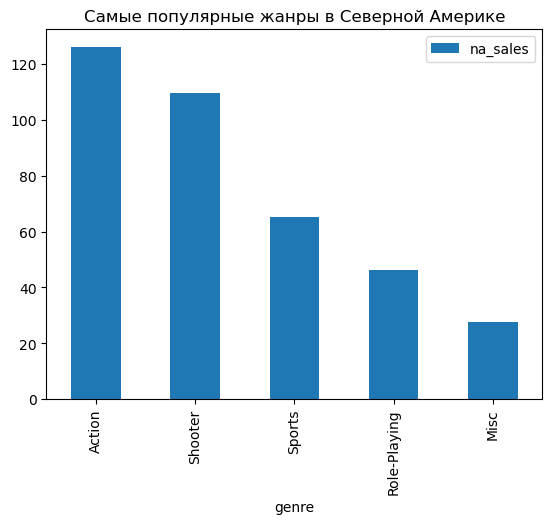

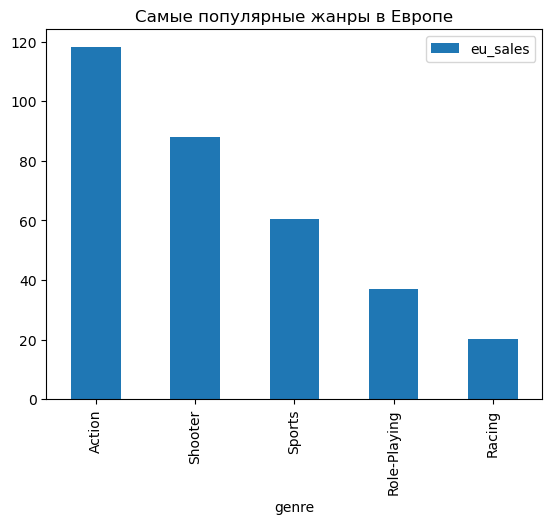

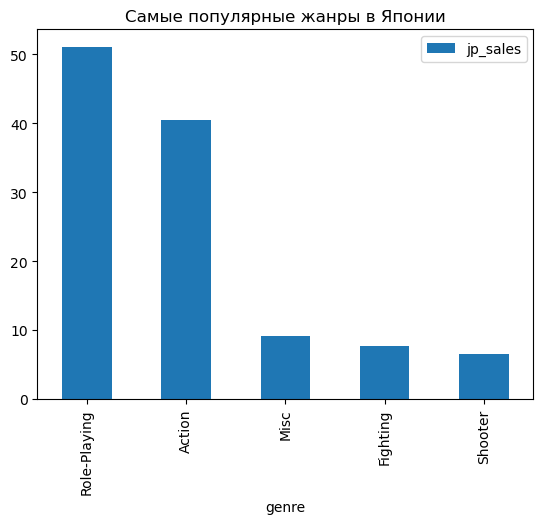

In [73]:
actual_games.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar', title = 'Самые популярные жанры в Северной Америке');

actual_games.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar', title = 'Самые популярные жанры в Европе');

actual_games.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar', title = 'Самые популярные жанры в Японии');

 В Европе и Америке лидируют action, shoots и sports, в Японии role-playing и action, скорее всего это зависит от минталитета Японцев

*1) Влияет ли рейтинг ESRB на продажи в отдельном регионе?*

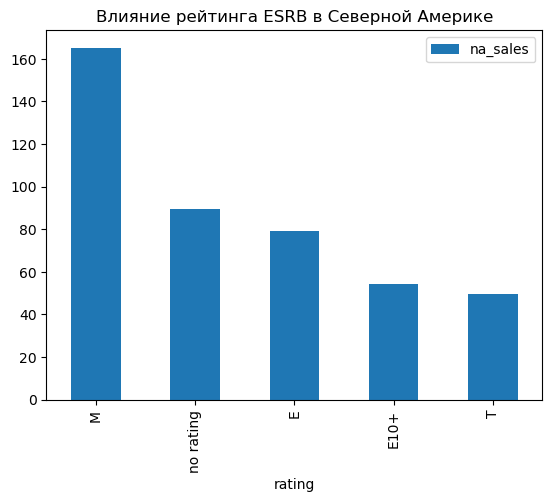

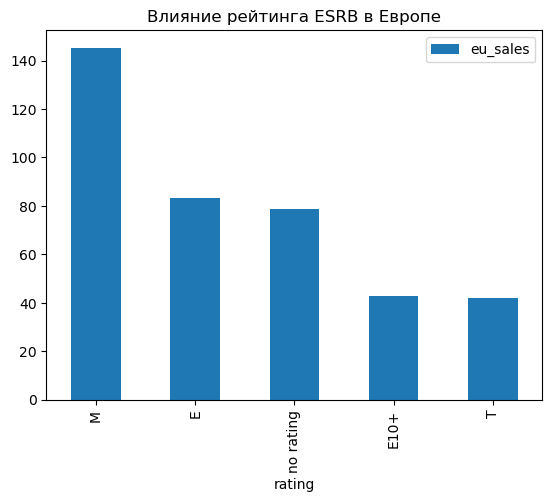

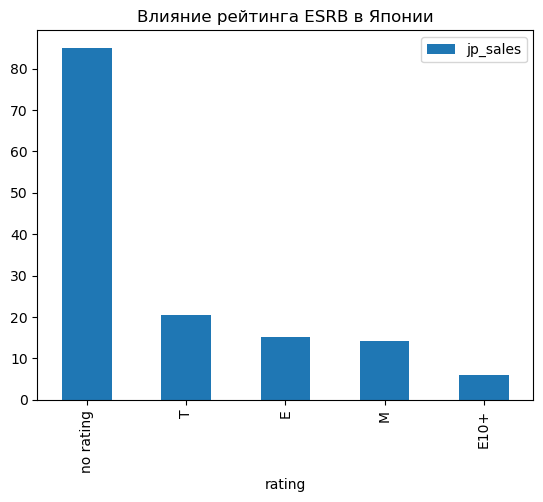

In [74]:
actual_games.groupby(by='rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).plot(kind='bar', title = 'Влияние рейтинга ESRB в Северной Америке');

actual_games.groupby(by='rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).plot(kind='bar', title = 'Влияние рейтинга ESRB в Европе');

actual_games.groupby(by='rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).plot(kind='bar', title = 'Влияние рейтинга ESRB в Японии');

В Америке и Европе наиболее продаваемы игры в с категорией М (из инета «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.). В выборке в Японии много игр вне рейтинга, из тех, что в рейтинге в тройке Т, Е и М («T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. «E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов. )

## Проверим гипотезы
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.



**Средние пользовательские рейтинги платформ Xbox One и PS одинаковые**
- H0: Средние пользовательские рейтинги платформ Xbox One и PS одинаковые 
- Н1: Средние пользовательские рейтинги платформ Xbox One и PS различные
- alpha = .05

In [ ]:
xb_user_score = games_XOne.loc[games_XOne['user_score'] > 0]['user_score']
ps_user_score = games_ps4.loc[games_ps4['user_score'] > 0]['user_score']

alpha = 0.05

results = st.ttest_ind(
    xb_user_score, 
    ps_user_score)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Вывод: Средние пользовательские рейтинги платформ Xbox One и PS  статистически значимо не различаются.

**Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

- H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
- Н1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
- alpha = .05

In [ ]:
action_user_score = actual_games.loc[(actual_games['genre'] == 'Action') & (actual_games['user_score'] > 0)]['user_score']
sports_user_score = actual_games.loc[(actual_games['genre'] == 'Sports') & (actual_games['user_score'] > 0)]['user_score']

alpha = 0.05

results = st.ttest_ind(
    action_user_score, 
    sports_user_score)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Вывод: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») статистически значимо различаются.

Для проверки гипотез применили t-критерий Стьюдента, тк выборки независимы между собой.

### Общий вывод

Были представленны данные о продажах интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры.

Цель исследования - выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

На этапе предобработки данных привели к нижнему регистру названия стоблцов датафрейма. Тип данных в столбца year_of_release заменили на  int, в столбцае user_score на float и заполнили пропуски в этих столбцах. В столбце rating заменили пропущенные значения фразой "non rating". Посчитали суммарные продажи во всех регионах и записали их в отдельный столбец total_sales. 

В ходе проведения исследовательского анализа пришли к следующим выводам: 
- платформы PS и XB имеют наибольшие суммарные продажами
- новые платформы появляются примерно за 6 лет, исчезают за 10 
- связь между отзывами критиков на платформе и продажами присутствует, но слабая, возможно, при покупке игры, некоторые пользователи обращают на них внимание. Связи между оценками пользователей и продажами нет
- самым прибыльным оказался жанр shooter (стрелялка). С низкими продажами - жанр adventure
- портреты пользователей из Северной Америки, Европы и Японии отличаются:
В Северной Америке самыми популярными оказались платформы PS и XB и находятся примерно на одном уровне. В пятерку также вошла 3DS. В Европе наибольшую популярность имеет платформа PS4, в Японии в лидерство выбивается 3DS, тк это японская компания, возможно, лидерство обусловленно тем, что на платформе выходили игры, актуальные для Японии (анимешные какие-то...), + это прототипная платформа, удобно взять с собой. На втором месте PS, скорее всего потому что это японская платформа, а XB американская. В Европе и Америке лидируют жанры action, shoots и sports, в Японии role-playing и action, скорее всего это зависит от минталитета Японцев. В Америке и Европе наиболее продаваемы игры в с категорией М (из инета «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.). В выборке в Японии много игр вне рейтинга, из тех, что в рейтинге в тройке Т, Е и М («T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. «E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов.)
- Средние пользовательские рейтинги платформ Xbox One и PS статистически значимо не различаются
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») статистически значимо различаются.